In [1]:
# Imported Libraries
import pennylane as qml
from pennylane.optimize import AdamOptimizer
from pennylane import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from graphs import plot_correlation_matrix
import random

import torch
from torchvision import datasets, transforms

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path
sys.path.append 

from qencode.initialize import setAB_amplitude, setAux, setEnt
from qencode.encoders import e5_patch
from qencode.training_circuits import swap_t
from qencode.qubits_arrangement import QubitsArrangement

from qencode.utils.mnist import get_dataset

In [3]:
!pip install kaggle

In [4]:
from kaggle.api.kaggle_api_extended import KaggleApi
#import KaggleApi
api = KaggleApi()
api.authenticate()

https://www.kaggle.com/mlg-ulb/creditcardfraud/download
#downloading datasets for COVID-19 data
#api.dataset_download_files('imdevskp/corona-virus-report')
api.dataset_download_files('mlg-ulb/creditcardfraud')

SyntaxError: invalid syntax (2387988877.py, line 6)

In [ ]:
df = pd.read_csv('creditcard.csv')

First, we import the credit card data set. We are only going to print the first 5 rows because the dataset contains over 280,000 rows. Each row represents a transaction. Time shows the time passed between the current and first transactions and amount shows the dollar amount spent on the transaction. There are also 28 more features represented by V1, V2, ... , V28 which come from principal component analysis. Finally, there is the class, where a '0' represents no fraud committed and a '1' represents a fraudulent transaction

Let's now check the class distribution

In [4]:
print('No Frauds: ', df['Class'].value_counts()[0])
print('Frauds: ', df['Class'].value_counts()[1])

No Frauds:  284315
Frauds:  492


Credit card fraud is relatively rare, this creates a very imbalanced distribution. A very imbalanced distribution is not ideal as this can lead to overfitting and our model assuming no fraud most of the time. It is also challenging to find the true correlations between the features and class.

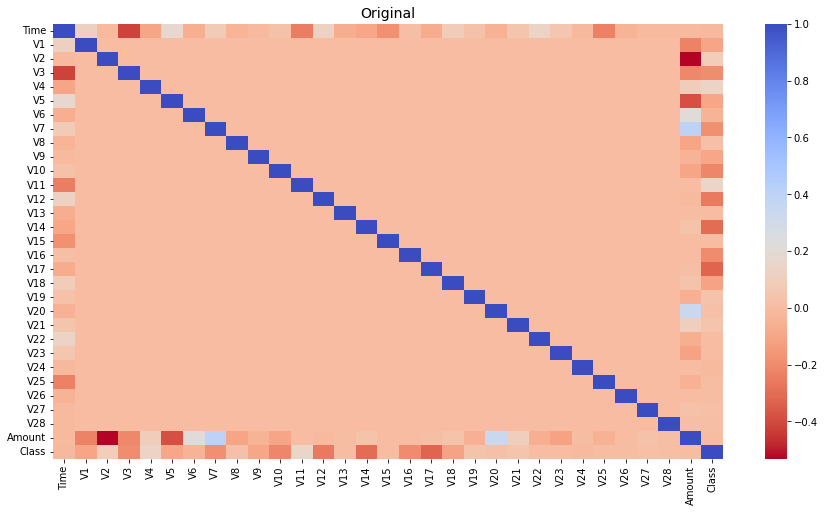

In [5]:
plot_correlation_matrix(df, "Original")

In [6]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# Scaling amount and time for the subsample
df['scaled_amount'] = RobustScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = RobustScaler().fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)


scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)



df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [7]:

df = df.sample(frac=1)
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
sub_sample_df = normal_distributed_df.sample(frac=1, random_state=42)

sub_sample_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
76898,-0.200377,-0.327741,-2.403144,0.297401,1.222089,1.068222,1.932852,-1.109267,0.757013,0.076495,...,-0.275728,0.075796,-0.014857,-0.798431,0.139255,0.724887,-0.196719,-0.268613,-0.535483,0
47802,0.922239,-0.485473,-3.365319,2.426503,-3.752227,0.276017,-2.305870,-1.961578,-3.029283,-1.674462,...,-0.036837,2.070008,-0.512626,-0.248502,0.126550,0.104166,-1.055997,-1.200165,-1.012066,1
124046,-0.061483,-0.088511,0.008361,-0.316874,1.886044,-1.987556,-1.218211,-0.736891,-0.221150,-0.345891,...,-0.246982,-0.340209,-0.531938,0.011522,0.326750,-0.348553,-0.490143,-0.224137,-0.195913,0
30496,1.253406,-0.572598,-4.844372,5.649439,-6.730396,5.252842,-4.409566,-1.740767,-6.311699,3.449167,...,0.284555,1.194888,-0.845753,0.190674,-0.216443,-0.325033,-0.270328,0.210214,0.391855,1
274382,-0.307413,0.955004,-5.766879,-8.402154,0.056543,6.950983,9.880564,-5.773192,-5.748879,0.721743,...,2.493224,0.880395,-0.130436,2.241471,0.665346,-1.890041,-0.120803,0.073269,0.583799,1


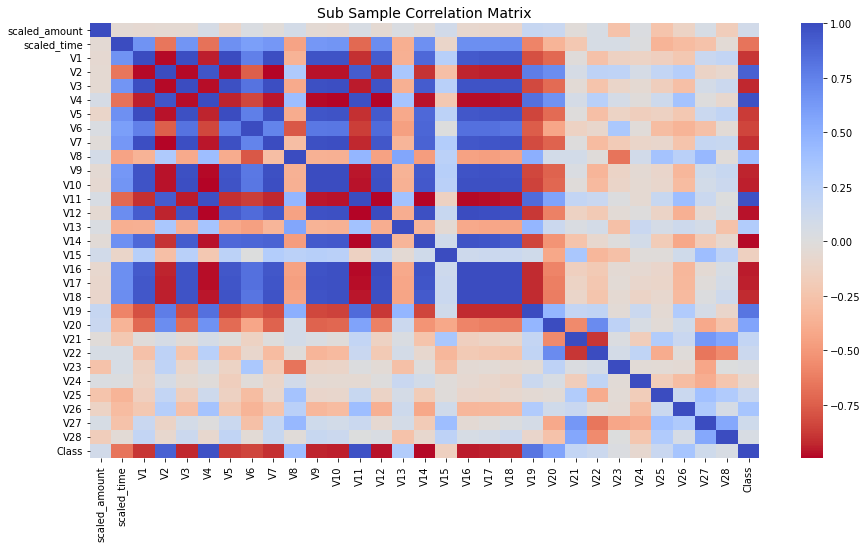

In [8]:
sub_sample_corr = sub_sample_df.corr()
plot_correlation_matrix(sub_sample_corr, "Sub Sample Correlation Matrix")

Find the features with the strongest correlation to class. Half are the strongest positive correlations, half are the strongest negative correlations. 

In [9]:
def find_strongest_correlations(dataframe, latent_qubits):
    
    num_features = latent_qubits**2
    
    class_correlations = dataframe.loc['Class', :]
    class_correlations = class_correlations.drop(index = 'Class')
    
    feature_list = list(class_correlations.index)
    correlation_list = [class_correlations[x] for x in feature_list]
    
    features = []
    correlations = []
    
    for i in range(int(num_features/2)):
        
        
        correlations.append(max(correlation_list))
        features.append(feature_list[correlation_list.index(max(correlation_list))])
        
        del feature_list[correlation_list.index(max(correlation_list))]
        del correlation_list[correlation_list.index(max(correlation_list))]                        
                                      
        correlations.append(min(correlation_list))
        features.append(feature_list[correlation_list.index(min(correlation_list))])
        
        del feature_list[correlation_list.index(min(correlation_list))]
        del correlation_list[correlation_list.index(min(correlation_list))] 
    
    return features, correlations
    
    
print(find_strongest_correlations(sub_sample_corr, 4))



(['V4', 'V14', 'V11', 'V12', 'V2', 'V10', 'V19', 'V16', 'V20', 'V3', 'V21', 'V17', 'V28', 'V9', 'scaled_amount', 'V7'], [0.7153889612076819, -0.7512860251743807, 0.6901739466233782, -0.6807855803365033, 0.47835217293872634, -0.6255349379817137, 0.2749047885289184, -0.5972343554376586, 0.1582511150611974, -0.5649277538174621, 0.133302893957455, -0.5614664297773682, 0.10911193395147353, -0.5557346159627801, 0.09996243728778707, -0.4758496821228639])


In [10]:
feature_list, correlations = find_strongest_correlations(sub_sample_corr, 4)


In [11]:
# Dataframe of all non fraudulent transactions
branch = df
non_fraud = branch[branch["Class"]!="1"]

# All examples of non fraudulent data with 8 features
non_fraud = non_fraud[feature_list]
non_fraud.head()

input_data = non_fraud.to_numpy()

# Training 

In [12]:
shots = 2500
nr_trash= 1
nr_latent= 3
nr_ent=0

trash_qubits1=[i for i in range(nr_trash)]
latent_qubits1=[i for i in range(nr_trash,nr_trash+nr_latent)]
trash_qubits2=[i for i in range(nr_trash+nr_latent,2*nr_trash+nr_latent)]
latent_qubits2=[i for i in range(2*nr_trash+nr_latent,2*(nr_trash+nr_latent))]
aux_qubits=[i for i in range(2*(nr_trash+nr_latent),2*(nr_trash+nr_latent)+2*nr_trash)]
swap_qubit=[2*(nr_trash+nr_latent)+2*nr_trash]

qubits=[*trash_qubits1, *latent_qubits1, *trash_qubits2, *latent_qubits2, *aux_qubits, *swap_qubit]

print("Qubits:", qubits)

#set up the device 
dev = qml.device("default.qubit", wires= qubits)

Qubits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [13]:
@qml.qnode(dev)
def training_circuit_example(init_params, encoder_params, reinit_state, x):
    # Initialization
    
    
    qml.templates.embeddings.AmplitudeEmbedding(
        init_params,
        wires=[*trash_qubits1, *latent_qubits1],
        normalize=True,
        pad_with=0.0j,
    )
  
    
    qml.templates.embeddings.AngleEmbedding(
        init_params[:4], wires=[*trash_qubits2, *latent_qubits2], rotation='X')
    qml.templates.embeddings.AngleEmbedding(
        init_params[:4], wires=[*trash_qubits2, *latent_qubits2], rotation='Z')
    
    qml.MottonenStatePreparation(reinit_state, wires=aux_qubits)

    #encoder 
    e5_patch(*encoder_params[0],*encoder_params[1], [*trash_qubits1, *latent_qubits1], [*latent_qubits2, *trash_qubits2])
    qml.CNOT(wires=[latent_qubits1[0],trash_qubits2[0]])
    qml.CNOT(wires=[latent_qubits2[0],trash_qubits1[0]])
    
    #swap test 
    trashes=[*trash_qubits1,*trash_qubits2]
    qml.Hadamard(wires=swap_qubit[0])
    for i in range(len(trashes)):
        qml.CSWAP(wires=[swap_qubit[0], aux_qubits[i], trashes[i]])
    qml.Hadamard(wires=swap_qubit[0])

    return [qml.probs(i) for i in swap_qubit]

In [14]:
epochs = 500
#learning_rate = 0.0003
learning_rate = .005
batch_size = 5
num_samples = 50 # proportion of the data used for training 

beta1 = 0.9
beta2 = 0.999
opt = AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2)

In [15]:
def fid_func(output):
    # Implemented as the Fidelity Loss
    # output[0] because we take the probability that the state after the 
    # SWAP test is ket(0), like the reference state
    fidelity_loss = 1 / output[0]
    return fidelity_loss

In [16]:
def cost(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state,x=x[0][1])[0]
        f = fid_func(output)
        loss = loss + f
    return loss / len(X)

In [17]:
def fidelity(encoder_params, X):
    reinit_state = [0 for _ in range(2 ** len(aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output =  training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state,x=x[0][1])[0]
       
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [18]:
def iterate_batches(X, batch_size):
    
    random.shuffle(X)

    batch_list = []
    batch = []
    for x in X:
        if len(batch) < batch_size:
            batch.append(x)

        else:
            batch_list.append(batch)
            batch = []
    if len(batch) != 0:
        batch_list.append(batch)
    return batch_list

In [19]:

training_data = [ torch.tensor([input_data[i]]) for i in range(num_samples)]
test_data = [ torch.tensor([input_data[i]]) for i in range(num_samples,num_samples+num_samples)]

X_training = training_data
X_tes = test_data



/var/folders/_6/ff1hjmgn32786plyc3tgkn8h0000gn/T/ipykernel_91567/3115814363.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  training_data = [ torch.tensor([input_data[i]]) for i in range(num_samples)]


In [20]:
# initialize random encoder parameters
nr_encod_qubits = nr_trash + nr_latent
nr_par_encoder =  15 * int(nr_encod_qubits*(nr_encod_qubits-1)/2)
encoder_params = [np.random.uniform(size=(1, nr_par_encoder), requires_grad=True),np.random.uniform(size=(1, nr_par_encoder), requires_grad=True)]

In [21]:
#fraud = df[df["Class"]=="1"]
fraud = fraud_df[feature_list]
np_fraud = fraud.to_numpy()
fraud_data = [ torch.tensor([np_fraud[i]]) for i in range(len(fraud.to_numpy()))]

fraud.head()


,V4,V14,V11,V12,V2,V10,V19,V16,V20,V3,V21,V17,V28,V9,scaled_amount,V7
144108,3.631947,-5.413787,3.369186,-5.691926,2.609127,-5.822449,2.794333,-5.863662,-0.178534,-5.568577,1.024423,-11.143241,-0.299728,-3.239901,4.030182,-4.089128
102444,3.320337,-9.072711,4.406806,-4.610756,12.785971,-5.052502,0.051576,-6.211557,-3.493050,-9.906650,27.202839,-6.248145,0.939407,-0.391540,-0.293440,-18.750889
150665,9.064478,-11.030110,7.154083,-17.150405,5.367416,-11.092392,1.982356,-12.448562,-0.081220,-10.054635,1.909032,-22.667905,0.197818,-5.324109,2.622092,-10.317566
63634,4.243069,-7.279869,2.826671,-6.309843,7.092197,-6.134907,0.596364,-4.215537,0.816652,-12.354037,0.926157,-7.171672,0.232758,-2.412987,1.089779,-8.058012
154286,1.064785,3.442422,1.368585,-1.471697,-1.093377,1.785922,-1.651766,-1.626129,-1.457610,-0.059768,1.160623,1.418215,0.424849,1.992110,-0.294557,-9.378025


In [22]:
loss_hist=[]
fid_hist=[]

loss_hist_test=[]
fid_hist_test=[]

fraud_fid=[]

for epoch in range(epochs):
    batches = iterate_batches(X=training_data, batch_size=batch_size)
    for xbatch in batches:
        encoder_params = opt.step(cost, encoder_params, X=xbatch)

        
    if epoch%5 == 0:
        
        loss_training = cost(encoder_params, X_training )
        fidel = fidelity(encoder_params, X_training )
        
        loss_hist.append(loss_training)
        fid_hist.append(fidel)
        print("Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_training, fidel))

        loss_test = cost(encoder_params, X_tes )
        fidel = fidelity(encoder_params, X_tes )
        loss_hist_test.append(loss_test)
        fid_hist_test.append(fidel)
        print("Test-Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_test, fidel))
        
        f_fidel = fidelity(encoder_params, fraud_data )
        fraud_fid.append(f_fidel)
        print("Fraud Fidelity:{}".format(f_fidel))

/Users/seanmcilvane/anaconda3/envs/ENV_NAME/lib/python3.8/site-packages/pennylane/_grad.py:105: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/Users/seanmcilvane/anaconda3/envs/ENV_NAME/lib/python3.8/site-packages/pennylane/math/multi_dispatch.py:65: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


ValueError: cannot reshape array of size 0 into shape (1,90)

fidelity: 0.9106666637654454


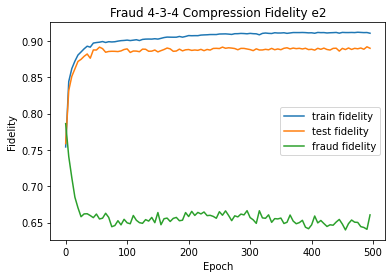

In [99]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist),label="train fidelity")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist_test),label="test fidelity")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fraud_fid),label="fraud fidelity")

plt.legend()
plt.title("Fraud 4-3-4 Compression Fidelity e2",)
plt.xlabel("Epoch")
plt.ylabel("Fidelity")
plt.savefig("Fraud 4-3-4 Compression Fidelity e2")

print("fidelity:",fid_hist[-1])

loss: 1.102373216675469


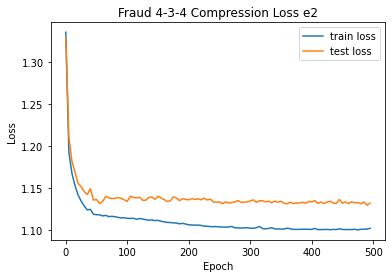

In [97]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist),label="train loss")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist_test),label="test loss")


plt.legend()
plt.title("Fraud 4-3-4 Compression Loss e2",)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("Fraud 4-3-4 Compression Loss e2")

print("loss:",loss_hist[-1])

In [96]:
name = "fraud_434_training_e2"

Circuit_prop={   "shots":shots, "nr_trash":nr_trash, "nr_latent":nr_latent, "nr_ent":nr_ent  }
Training_param = { "num_samples" == num_samples,
                    "batch_size" == batch_size,
                    #"nr_layers"== nr_layers,
                    "epochs" == epochs,
                    "learning_rate" == learning_rate, 
                    "beta1" == beta1,
                    "beta2 "== beta2,
                     "optimizer"=="Adam"}

performance={"loss_hist":loss_hist, "fid_hist":fid_hist,
             "loss_hist_test":loss_hist_test, "fid_hist_test":fid_hist_test,
             "encoder_params":encoder_params}

experiment_data={"Circuit_prop":Circuit_prop,
                "Training_param":Training_param,
                "performance:":performance,
                "Name":name}

# open file for writing
f = open(name+".txt","w")
f.write( str(experiment_data) )

17547

In [101]:
experiment_parameters={"autoencoder":"e2","params":encoder_params}
f=open("Params_Fraud_encoder_e2-CorrelatedFeautures.txt","w")
f.write(str(experiment_parameters))

1386

In [144]:
branch = df 
non_fraud_df = branch.loc[branch["Class"]!=1][:492]


non_fraud = non_fraud_df[feature_list]
np_non_fraud = non_fraud.to_numpy()
non_fraud_data = [ torch.tensor([np_non_fraud[i]]) for i in range(len(non_fraud.to_numpy()))]

non_fraud_flist=[]
for b in non_fraud_data:
    f=fidelity(encoder_params, [b])
    non_fraud_flist.append(f.item())
    
print(min(non_fraud_flist))
print(max(non_fraud_flist))

0.52082426012579
0.9739451826962489


In [136]:
#np_ilegal= ilegal.to_numpy()
#ilegal_data = [ torch.tensor([np_ilegal[i]]) for i in range(len(ilegal.to_numpy()))]


fraud_flist=[]
for b in fraud_data:
    f=fidelity(encoder_params, [b])
    fraud_flist.append(f.item())
    
print(min(fraud_flist))
print(max(fraud_flist))

/Users/seanmcilvane/anaconda3/envs/ENV_NAME/lib/python3.8/site-packages/pennylane/math/multi_dispatch.py:65: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


0.5213199366767333
0.9336154283701765


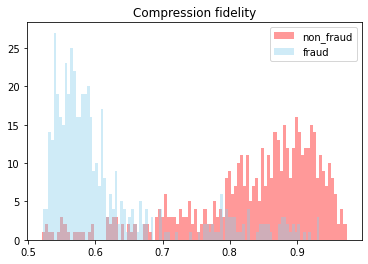

In [146]:

plt.hist(non_fraud_flist, bins =100 ,label="non_fraud",color = "red",alpha=0.4)
plt.hist(fraud_flist, bins = 100 ,label="fraud", color = "skyblue",alpha=0.4)
plt.title("Compression fidelity",)
plt.legend()
plt.savefig("Compression_fidelity")
plt.show()

In [40]:
# Potential stuff for QAOA 

features, correlations = find_strongest_correlations(sub_sample_corr, 6)

norm = sum(abs(x) for x in correlations)
print(norm)
norm_correlations = [x/norm for x in correlations]
print(norm_correlations)




# Have to define backend and optimizer
backend = Aer.get_backend('qasm_simulator')
optimizer = COBYLA(maxiter = 1000, disp = True, tol=.000001)

This problem was very challenging but was still fun to work on. I would have done better with more time, but I understand the short time period was an element in the assigment. While I ran out of time, my goal was to implement the QAOA to find a hyperplane to be a binary classifier to discriminate between fraud and no fraud classes. The approach includes using the dual formulation [1]:
\begin{equation}
    L = \sum_{j=1}^{M} y_j*\alpha_j - \frac{1}{2} \sum_{j,k=1}^{M} \alpha_j*K_{jk}*\alpha_k  
\end{equation}



I then planned on using:

\begin{equation}
    w = \sum_{j=1}^{M} x_j\alpha_j
\end{equation}

and 

\begin{equation}
    b = y_j - wx_j
\end{equation}

to get the parameters for the binary classifier:

\begin{equation}
    y(x) = sign(\sum_{j=1}^{M} \alpha_jk(x_j,x) + b)
\end{equation}



[1] S. Boyd and L. Vandenberghe, Convex Optimization (Cam-
    bridge University Press, 2004).